In [1]:
import os
import gym
import pylab
import random
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tqdm.auto import tqdm
from collections import deque

In [3]:
warnings.filterwarnings(action='ignore')

In [4]:
#
# Environment
#
env = gym.make('CartPole-v1')
state = env.reset()
action = env.action_space.sample()

print('State space: ', env.observation_space)
print('Initial state: ', state)
print('\nAction space: ', env.action_space)
print('Random action: ', action)

State space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Initial state:  [-0.00011524  0.02978837  0.00750123  0.03458011]

Action space:  Discrete(2)
Random action:  0


In [5]:
# Q - Network 생성 Class
class Q_NetWork() :
    def __init__(self, num_state, num_action, learning_rate) :
        self.num_state = num_state
        self.num_action = num_action
        
    def build(self):
        self.input_layer = tf.keras.Input(shape = self.num_state, name = "input")
        self.dense_layer = tf.keras.layers.Dense(units = 32, activation='relu')(self.input_layer)
        self.dense_layer = tf.keras.layers.Dense(units = 32, activation='relu')(self.dense_layer)
        self.output_layer = tf.keras.layers.Dense(units = self.num_action,  # 마지막 층의 가중치를 작은 범위안에서 초기화 하는 것 중요
                                                  kernel_initializer=tf.keras.initializers.RandomUniform(-1e-3, 1e-3))(self.dense_layer)
        self.model = tf.keras.Model(self.input_layer, self.output_layer)  
        self.optim = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = self.optim, loss = 'mse')
        
    # custom loss
    def loss(y_true, y_pred):
        mean = tf.reduce_mean(abs(y_true - y_pred)**2)
        std  = 1/(tf.math.reduce_std(y_pred) + 1/mean)
        return mean + std**2    

In [6]:
# Parameter Setting
num_state       = 4
num_action      = 2
discount_factor = 0.99
learning_rate   = 0.001
epsilon         = 1
epsilon_decay   = 0.999
epsilon_min     = 0.01
batch_size      = 64
train_start     = 1000

In [7]:
# Set Max Memory 2000 -> First In, First Out 방식으로 저장됨
memory = deque(maxlen = 2000)

In [8]:
# Q - NetWork Model 생성
model = Q_NetWork(num_state, num_action, learning_rate)
model.build()

# Target Model 생성
target_model = Q_NetWork(num_state, num_action, learning_rate)
target_model.build()

# model과 target_model의 weight 동일하게 지정(모델 생성기 가중치가 무작위로 초기화 되기 떄문에 같지 않음)
target_model.model.set_weights(model.model.get_weights())

# Weight가 동일하게 지정 되었는지 체크
[np.mean(model.model.get_weights()[s] == target_model.model.get_weights()[s]) for s in range(len(model.model.get_weights()))]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [9]:
# 에피소드 수
num_episode = 200

# 점수 저장 
scores, episodes = [], []
score_avg = 0

In [10]:
for e in tqdm(range(num_episode)) :
    done = False # 해당 에피소드에서 게임 종료 여부
    score = 0
    
    # env 초기화
    state = env.reset() # Random State
    state = state.reshape(-1 , num_state)
    
    while not done :
        
        # 입실론 탐욕 정책으로 행동 선택
        if np.random.rand() <= epsilon :
            action = env.action_space.sample() # 랜덤하게 Action
        else :
            q_value = model.model.predict(state.reshape(-1 , num_state)) # Max Q Value 방향으로 Action
            action = np.argmax(q_value)

        # 선택한 action으로 한 타임스텝 진행    
        next_state, reward, done, info = env.step(action)    
        next_state = next_state.reshape(-1, num_state)

        score += reward

        # 각 스텝 마다 reward 0.1
        # 500 전에 쓰러지게 되면 reward -1
        reward = 0.1 if not done or score == 500 else -1

        # 리플레이 메모리에 샘플 <s,a,r,s'> 저장
        memory.append((state, action, reward, next_state, done))

        state = next_state


        # ===============================================
        # Q - NetWork Model Train
        # ===============================================

        # Memory에 데이터가 일정량 이상 생기면 모델 학습 
        # Memory가 일정량 미만이면 다음 에피소드에서 데이터 생성해서 학습 진행
        if len(memory) > train_start :

            # epsilon을 점차 줄여감
            if epsilon > epsilon_min :
                epsilon *= epsilon_decay

            # Mini Batch 생성
            mini_batch = random.sample(memory, batch_size)

            states      = np.array([sample[0][0] for sample in mini_batch])
            actions     = np.array([sample[1]    for sample in mini_batch])
            rewards     = np.array([sample[2]    for sample in mini_batch])
            next_states = np.array([sample[3][0] for sample in mini_batch])
            dones       = np.array([sample[4]    for sample in mini_batch])

            # >> 이 부분을 잘 이해해 보자 Start <<
            # target y 생성 =====================================
            target_f       = target_model.model.predict(next_states)              # Next States 에서 얻을 수 있는 Q - Value
            max_q          = [np.max(target_f[s]) for s in range(len(target_f))] # Q - Value Max 값 추출
            update_val     = rewards + (1-dones) * discount_factor * max_q       # 즉각적인 리워드 + 다음스테이트 Max Q Value            
            
            target = target_model.model.predict(states) # 현재 State 에서 얻은 Q - Value
            
            
            # 현재 State 에서 얻은 Q - Value 값이 있음
            # 현재 Action이 Mamery에 저장되어 있고, 그 Action으로 인한 Next State 가 저장되어 있음
            # Q - Value 값은 즉각적으로 얻을 수 있는 Reward + DisCount_Factor * Max_Q
        
            update_rate = 0.3 # Q-Value 업데이트 비율
            
            # Q - Value 업데이트는 현재 State에서 현재 Action에 의해 발생하는 것이므로, 해당 Action의 Target만 수정
            # 원래 값에서 update_rate 비율 만큼 씩 업데이트
            for idx in range(len(target)) :
                target[idx][actions[idx]] = (1-update_rate)*target[idx][actions[idx]] + update_rate*update_val[idx]
            
            # model update 
            model.model.fit(states, target, batch_size = batch_size, verbose=0)
            # >> 이 부분을 잘 이해해 보자 End <<
                 
            
    # 하나의 에피소드가 끝나면
    if done :
        # 타겟 모델의 가중치 업데이트
        target_model.model.set_weights(model.model.get_weights())

        score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
        
        if (e+1)%(num_episode/10) == 0 :
            print(f'episode : {e+1} / score avg : {score_avg:.2f} / memory length : {len(memory)} / epsilon : {epsilon:.4f}')

        scores.append(score_avg)
        episodes.append(e)

episode : 20 / score avg : 23.74 / memory length : 458 / epsilon : 1.0000
episode : 40 / score avg : 23.17 / memory length : 955 / epsilon : 1.0000
episode : 60 / score avg : 45.26 / memory length : 1715 / epsilon : 0.4890
episode : 80 / score avg : 287.31 / memory length : 2000 / epsilon : 0.0100
episode : 100 / score avg : 415.98 / memory length : 2000 / epsilon : 0.0100
episode : 120 / score avg : 485.25 / memory length : 2000 / epsilon : 0.0100
episode : 140 / score avg : 480.29 / memory length : 2000 / epsilon : 0.0100
episode : 160 / score avg : 469.04 / memory length : 2000 / epsilon : 0.0100
episode : 180 / score avg : 470.63 / memory length : 2000 / epsilon : 0.0100
episode : 200 / score avg : 482.91 / memory length : 2000 / epsilon : 0.0100



Text(0, 0.5, 'average score')

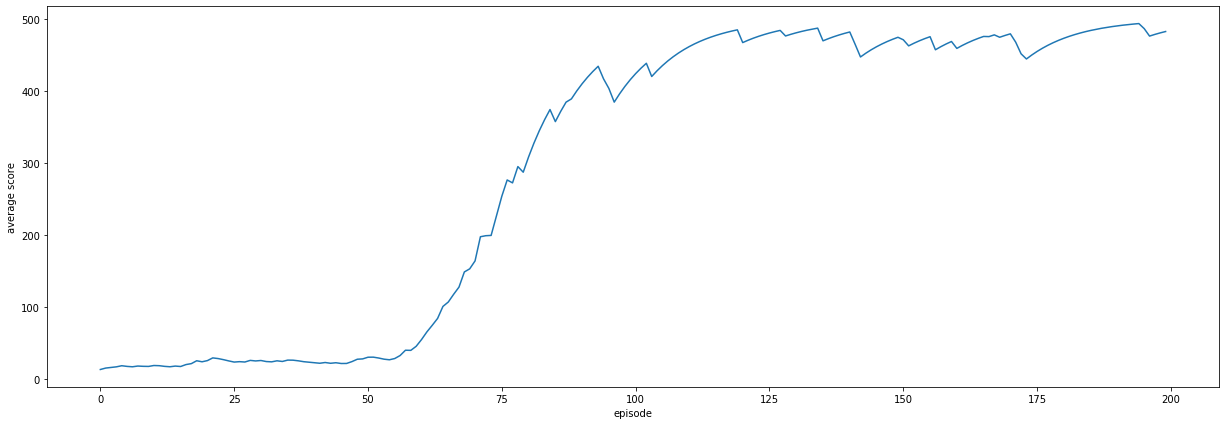

In [11]:
# plot
fig, ax = plt.subplots(1,1, figsize = (21,7))

sns.lineplot(episodes, scores, ax = ax)
ax.set_xlabel("episode")
ax.set_ylabel('average score')

In [12]:
# Model Save
save_dir = 'C:/Users/begas/DQN_Model'
os.makedirs(save_dir, exist_ok=True)
model_name = 'keras_dqn_trained_model.h5'

# Save model and weights
model_path = os.path.join(save_dir, model_name)
model.model.save(model_path)